In [4]:
%matplotlib inline

from glob import glob

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import warnings
from functools import partial

In [37]:
from scipy.optimize import curve_fit
from scipy.stats import linregress
from itertools import chain

def linear_fit_func(x, m, b):
    return x*m+b

def fit_image(da, log=False):
    """
    Find a linear fit to 2D histogram data in DataArray da by
    brute-force replication of an observation at each bin location, so
    as to generate a scattered point dataset consistent with the histogram.
    
    The values in da are assumed to be integers, and cast as ints if not.
    
    There's an additional correction that could be done to account for
    the known discretization error as a function of bin size.
    """
    img = da.values
    
    if log == True:
        xb = np.log10(da[da.dims[1]])
        yb = np.log10(da[da.dims[0]])
    else:
        xb = da[da.dims[1]]
        yb = da[da.dims[0]]
    
    Xb, Yb = np.meshgrid(xb,yb)
    X = Xb.flatten()
    Y = Yb.flatten()
    Z = img.flatten()

    good = (Z>0)
    
    # total samples
    N = Z.sum()
    
    xy = list(chain.from_iterable(
            ( [(Xi,Yi)]*Zi
             for Xi, Yi, Zi in zip(X[good], Y[good], Z[good]))
            ))
    xy = np.asarray(xy)

    return linregress(xy[:,0], xy[:,1]), xb

def regress_plot(da, ax, log=True):
    regress, xb = fit_image(da, log=log)
    yfit =  regress.slope*xb + regress.intercept
    if log==True:
        ax.plot(10**xb, 10**yfit, color='k')
    else:
        ax.plot(xb, yfit, color='k')
    ax.text(0.02, .98, 
            f"m = {regress.slope:0.1e}\nb = {regress.intercept:0.1e}\n$r$ = {regress.rvalue:0.2f}\np = {regress.pvalue:0.3f}", 
            transform=ax.transAxes, horizontalalignment='left', verticalalignment='top',)

    

In [34]:
def aggregate_histos(histo_filenames):
    histo_iter = (xr.open_dataset(fn) for fn in histo_filenames)
    cleaned = [ds.drop(['grid_time_start', 'grid_time_end']) for ds in histo_iter]
    N_histos = len(histo_filenames)
    ds = xr.combine_nested(cleaned, concat_dim='day', combine_attrs='override').sum(dim='day', keep_attrs=True)
    
    # Find the mean of the percentiles on each day.
    percentile_vars = [v for v in list(ds.variables.keys()) if 'percentile' in v]
    for v in percentile_vars:
        if 'thresholds' in v:
             pass
        else:
            ds[v] /= N_histos
    ds['track_maximum_distance_km'] /= N_histos
            
    return ds

Based on a ranking of daily Zdr/Kdp/Lightning fractions, here are the quartiles, from smallest lightning fraction to greatest.

Manually analyzed by using the track_count_constmelt.csv output.

Note that the days with the low lightning fractions have very many tracks - warm rain dominated cells. Only 3 days to get 25% of all tracks in the whole dataset. Meanwhile, high lightning fraction days have progressively fewer tracks: 5, 7, and 10 days for increasing lightning fractions quartiles.



In [7]:

# By count of all tracks on the day
lightning_fraction_quartiles_by_all_track_count = [
    ("2022-08-31", "2022-09-15", "2022-09-01"),
    ("2022-08-25", "2022-08-08", "2022-07-13", "2022-08-07", "2022-08-13"),
    ("2022-09-17", "2022-06-04", "2022-08-02", "2022-07-12", "2022-08-27", "2022-08-01", "2022-07-02"),
    ("2022-08-06", "2022-06-22", "2022-06-02", "2022-07-06", "2022-08-21", "2022-08-03", "2022-07-14", "2022-07-28", "2022-07-29", "2022-06-17"),
]


# By count of all zdr_kdp_ltg tracks on the day
lightning_fraction_quartiles_by_zdr_kdp_ltg_count = [
    ("2022-08-31", "2022-09-15", "2022-09-01", "2022-08-25", "2022-08-08", "2022-07-13", "2022-08-07", "2022-08-13"),
    ("2022-09-17", "2022-06-04", "2022-08-02", "2022-07-12", "2022-08-27", "2022-08-01"),
    ("2022-07-02", "2022-08-06", "2022-06-22", "2022-06-02", "2022-07-06", "2022-08-21"),
    ("2022-08-03", "2022-07-14", "2022-07-28", "2022-07-29", "2022-06-17"),
]

quartiles_by_all_track_count = True
if quartiles_by_all_track_count:
    lightning_fraction_quartiles = lightning_fraction_quartiles_by_all_track_count
else:
    lightning_fraction_quartiles = lightning_fraction_quartiles_by_zdr_kdp_ltg_count
    
this_quartile = None
# this_quartile = 3

In [12]:
track_categories = [
    "track_has_any",
    "track_has_zdr_kdp_ltg",
    "track_has_zdr_kdp_only",
    "track_has_zdr_ltg_only",
    "track_has_zdr_only",
    "track_has_nothing",
    "track_has_kdp_only",
    "track_has_kdp_ltg_only",
    "track_has_ltg_only",
    ]
zdr_categories = [c for c in track_categories if 'zdr' in c]
kdp_categories = [c for c in track_categories if 'kdp' in c]
zdr_ltg_categories = [c for c in zdr_categories if 'ltg' in c]
kdp_ltg_categories = [c for c in kdp_categories if 'ltg' in c]

this_category = "track_has_any"
# this_category = "track_has_zdr_kdp_ltg"
const_melt = True

In [13]:
# all_histos_both_melt = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*.nc'))
# const_melt_histos = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data*4400.nc'))
# # The 4 June case has the same melting height our constant case
# vary_melt_histos = sorted([hf for hf in all_histos_both_melt if not(hf in const_melt_histos)] 
#                     + glob('/efs/tracer/NEXRAD/tobac_Save_20220604/histogram_data*4400.nc'))

# # Just look at one day
# # all_histos_both_melt = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data*.nc'))
# # const_melt_histos = sorted(glob('/efs/tracer/NEXRAD/tobac_Save_20220807/histogram_data*4400.nc'))

# # for hf in zip(const_melt_histos, vary_melt_histos):
#     # print(hf)

# assert len(vary_melt_histos) == len(const_melt_histos)

# if const_melt:
#     all_histos = const_melt_histos
# else:
#     all_histos = vary_melt_histos

In [14]:
lightning_fraction_quartile_paths = [
    ['/efs/tracer/NEXRAD/tobac_Save_{1}/histogram_data_{0}_melt4400.nc'.format(
        this_category.replace('_','-'), di.replace('-', '')) for di in ds] 
    for ds in lightning_fraction_quartiles]


In [15]:
# all days
pathstring_all_days = '/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data_{0}_melt4400.nc'.format(this_category.replace('_','-'))

if this_quartile is not None:
    all_histos = lightning_fraction_quartile_paths[this_quartile]
else:
    all_histos = sorted(glob(pathstring_all_days))
print(all_histos)

['/efs/tracer/NEXRAD/tobac_Save_20220602/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220604/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220617/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220622/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220702/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220706/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220712/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220713/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220714/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220728/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220729/histogram_data_track-has-any_melt4400.nc', '/efs/tracer/NEXRAD/tobac_Save_20220801/histogram_data_track-has-any_melt4400.nc', '/e

In [16]:
# # Diagnose a variable that doesn't seem to be there.
# for hfn in all_histos:
#     hds = xr.open_dataset(hfn)
#     findme = 'histogram_feature_flash_count_area_time_norm_feature_kdpcol_area_time_norm'
#     print(hfn.split('/')[-2], findme in hds.variables)

In [17]:
# odd_ds = xr.open_dataset('/efs/tracer/NEXRAD/tobac_Save_20220803/histogram_data_track-has-zdr-kdp-only_melt4400.nc')

In [18]:
# odd_ds

In [19]:
histo_ds2 = xr.open_dataset(all_histos[0])

In [20]:
histo_ds2

<xarray.Dataset>
Dimensions:                                                                                         (
                                                                                                     feature_flash_count_area_time_norm_bin: 26,
                                                                                                     feature_kdpcol_area_time_norm_bin: 26,
                                                                                                     feature_kdpcol_total_area_time_norm_bin: 26,
                                                                                                     feature_kdpvol_area_time_norm_bin: 26,
                                                                                                     feature_kdpwt_total_area_time_norm_bin: 26,
                                                                                                     ...
                                                                                                     feature_flash_count_bin: 26,
                                                                                                     feature_kdpcol_bin: 26,
                                                                                                     feature_rhvdeficitcol_bin: 26,
                                                                                                     feature_zdrvol_bin: 26,
                                                                                                     percentile_thresholds: 3,
                                                                                                     track_count: 1)
Coordinates: (12/24)
  * feature_flash_count_area_time_norm_bin                                                          (feature_flash_count_area_time_norm_bin) float64 ...
  * feature_kdpcol_area_time_norm_bin                                                               (feature_kdpcol_area_time_norm_bin) float64 ...
  * feature_kdpcol_total_area_time_norm_bin                                                         (feature_kdpcol_total_area_time_norm_bin) float64 ...
  * feature_kdpvol_area_time_norm_bin                                                               (feature_kdpvol_area_time_norm_bin) float64 ...
  * feature_kdpwt_total_area_time_norm_bin                                                          (feature_kdpwt_total_area_time_norm_bin) float64 ...
  * feature_nearby_count_10km_bin                                                                   (feature_nearby_count_10km_bin) float64 ...
    ...                                                                                              ...
  * feature_flash_count_bin                                                                         (feature_flash_count_bin) float64 ...
  * feature_kdpcol_bin                                                                              (feature_kdpcol_bin) float64 ...
  * feature_rhvdeficitcol_bin                                                                       (feature_rhvdeficitcol_bin) float64 ...
  * feature_zdrvol_bin                                                                              (feature_zdrvol_bin) float64 ...
  * percentile_thresholds                                                                           (percentile_thresholds) int64 ...
  * track_count                                                                                     (track_count) int64 ...
Data variables: (12/258)
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_area_time_norm                      (feature_flash_count_area_time_norm_bin, feature_kdpcol_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_total_area_time_norm                (feature_flash_count_area_time_norm_bin, feature_kdpcol_total_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpvol_area_time

In [21]:
agg_histo_ds = aggregate_histos(all_histos)

In [22]:
from itertools import combinations
paper_vars = ['feature_flash_count_area_time_norm',
 'feature_zdrwt_total_area_time_norm',
 'feature_kdpwt_total_area_time_norm',
 'feature_rhvdeficitwt_total_area_time_norm',
 'feature_nearby_count_20km_area_time_norm',
]

In [23]:
agg_histo_ds

<xarray.Dataset>
Dimensions:                                                                                         (
                                                                                                     feature_flash_count_area_time_norm_bin: 26,
                                                                                                     feature_kdpcol_area_time_norm_bin: 26,
                                                                                                     feature_kdpcol_total_area_time_norm_bin: 26,
                                                                                                     feature_kdpvol_area_time_norm_bin: 26,
                                                                                                     feature_kdpwt_total_area_time_norm_bin: 26,
                                                                                                     ...
                                                                                                     feature_flash_count_bin: 26,
                                                                                                     feature_kdpcol_bin: 26,
                                                                                                     feature_rhvdeficitcol_bin: 26,
                                                                                                     feature_zdrvol_bin: 26,
                                                                                                     percentile_thresholds: 3,
                                                                                                     track_count: 1)
Coordinates: (12/24)
  * feature_flash_count_area_time_norm_bin                                                          (feature_flash_count_area_time_norm_bin) float64 ...
  * feature_kdpcol_area_time_norm_bin                                                               (feature_kdpcol_area_time_norm_bin) float64 ...
  * feature_kdpcol_total_area_time_norm_bin                                                         (feature_kdpcol_total_area_time_norm_bin) float64 ...
  * feature_kdpvol_area_time_norm_bin                                                               (feature_kdpvol_area_time_norm_bin) float64 ...
  * feature_kdpwt_total_area_time_norm_bin                                                          (feature_kdpwt_total_area_time_norm_bin) float64 ...
  * feature_nearby_count_10km_bin                                                                   (feature_nearby_count_10km_bin) float64 ...
    ...                                                                                              ...
  * feature_flash_count_bin                                                                         (feature_flash_count_bin) float64 ...
  * feature_kdpcol_bin                                                                              (feature_kdpcol_bin) float64 ...
  * feature_rhvdeficitcol_bin                                                                       (feature_rhvdeficitcol_bin) float64 ...
  * feature_zdrvol_bin                                                                              (feature_zdrvol_bin) float64 ...
  * percentile_thresholds                                                                           (percentile_thresholds) int64 ...
  * track_count                                                                                     (track_count) int64 ...
Data variables: (12/256)
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_area_time_norm                      (feature_flash_count_area_time_norm_bin, feature_kdpcol_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpcol_total_area_time_norm                (feature_flash_count_area_time_norm_bin, feature_kdpcol_total_area_time_norm_bin) int64 ...
    histogram_feature_flash_count_area_time_norm_feature_kdpvol_area_time

# Plotting from the standardized histogram dataset

In [24]:
def track_count_table(histo_ds):
    all_dims = list(histo_ds.dims.keys())
    dims_to_remove = [d for d in all_dims if d != 'track_count']
    ds = histo_ds.drop_dims(dims_to_remove)
    return ds.to_dataframe()

In [25]:
track_count_table(histo_ds2)

grid_time_start           grid_time_end  \
track_count                                                   
0           2022-06-02 00:05:22.842 2022-06-02 23:57:07.178   

             track_has_zdr_kdp_ltg  track_has_zdr_kdp_only  \
track_count                                                  
0                               60                      49   

             track_has_zdr_ltg_only  track_has_zdr_only  track_has_nothing  \
track_count                                                                  
0                                 6                  24                 37   

             track_has_kdp_only  track_has_kdp_ltg_only  track_has_ltg_only  \
track_count                                                                   
0                             0                       0                   0   

             track_maximum_distance_km  
track_count                             
0                                 90.0

In [26]:
track_count_table(agg_histo_ds)

track_has_zdr_kdp_ltg  track_has_zdr_kdp_only  \
track_count                                                  
0                             1600                     327   

             track_has_zdr_ltg_only  track_has_zdr_only  track_has_nothing  \
track_count                                                                  
0                               513                 390               4651   

             track_has_kdp_only  track_has_kdp_ltg_only  track_has_ltg_only  \
track_count                                                                   
0                             0                       1                   6   

             track_maximum_distance_km  
track_count                             
0                                 90.0

In [27]:
def plot_1d_hists(histo_ds):
    all_dims = list(histo_ds.dims.keys())
    dims_to_remove = [d for d in all_dims if d != 'percentile_thresholds']
    try:
        percentile_ds = histo_ds.drop_dims(dims_to_remove).drop('grid_time_start').drop('grid_time_end')
    except ValueError:
        print("Not dropping grid time start and end - not in the dataset")
        percentile_ds = histo_ds.drop_dims(dims_to_remove)
    percentile_ds = percentile_ds.drop('track_maximum_distance_km')
    
    # n_vars = len(percentile_ds.variables.keys())
    # violin_fig, violin_ax = plt.subplots(1,n_vars, figsize=(3,n_vars))
    
    
    all_figs = []
    for var in percentile_ds:
        bins = histo_ds[var.replace('percentile_','')+'_bin']
        counts = histo_ds[var.replace('percentile_','')]
        description = counts.attrs['long_name']
        fig, ax = plt.subplots(1,1)

        # ax.step(bins, counts, where='mid')
        ax.fill_between(bins, counts, step='mid')
        for thresh, thresh_val in zip(percentile_ds['percentile_thresholds'], percentile_ds[var]):
            ax.axvline(thresh_val, color='k', linewidth=0.5)
            ax.text(thresh_val, counts.max()*.9, f' {thresh_val:3.2e}')
        # ax.set_xlim(-1,15)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel("Number of tracks")
        ax.set_xlabel(description)
        ax.set_title("Track property distribution")
        all_figs.append(fig)
        
    return all_figs #, violin_fig, 

Not dropping grid time start and end - not in the dataset


/tmp/ipykernel_996/3783165694.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

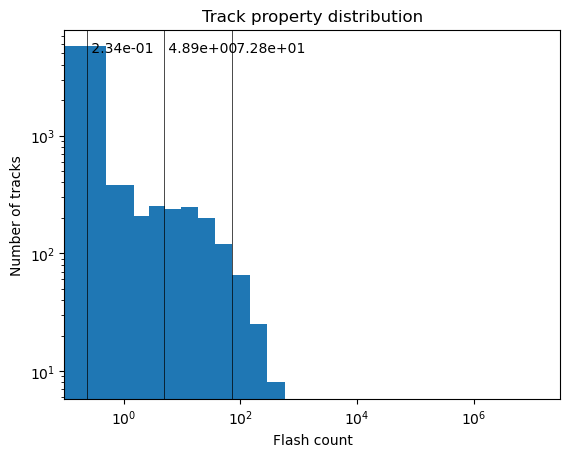

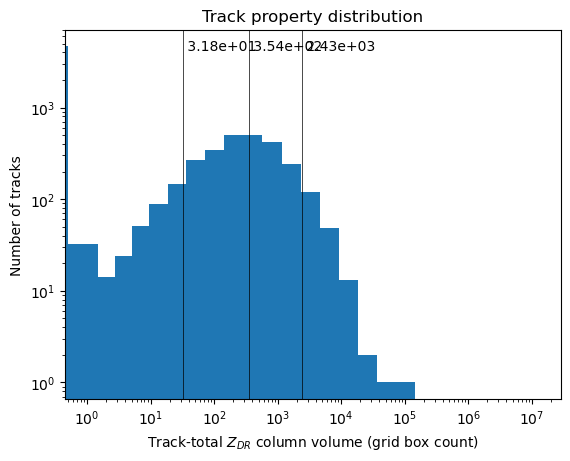

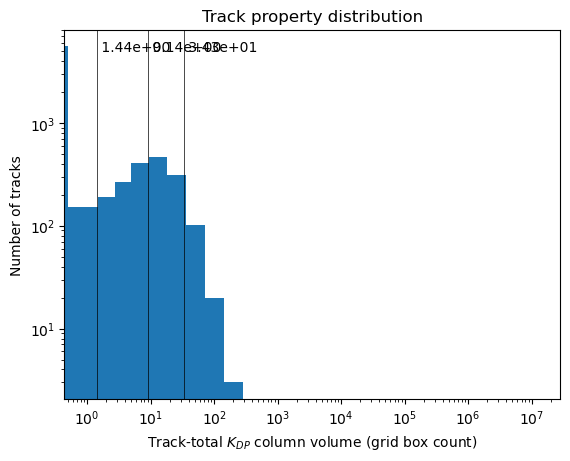

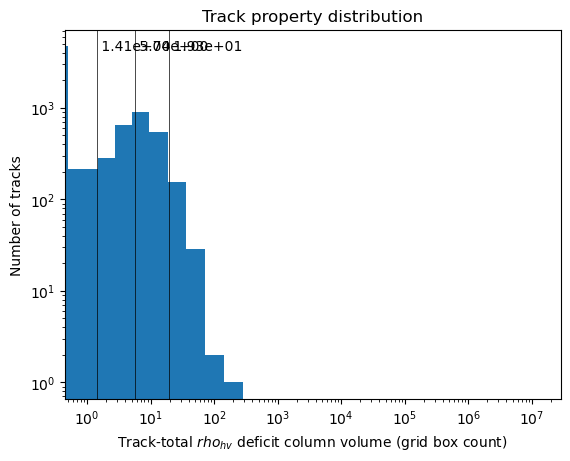

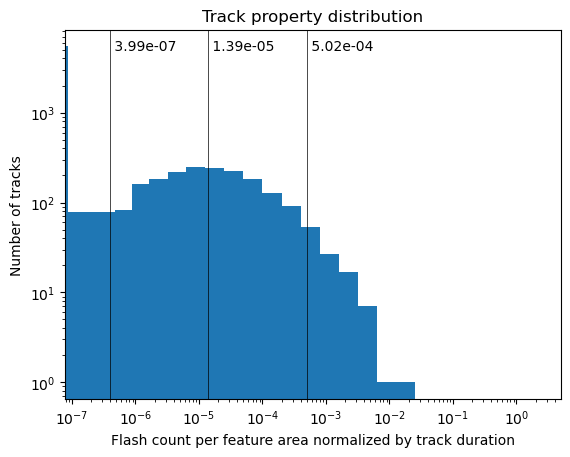

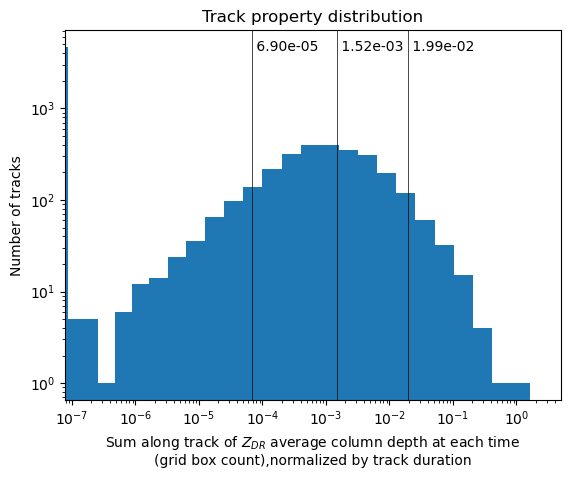

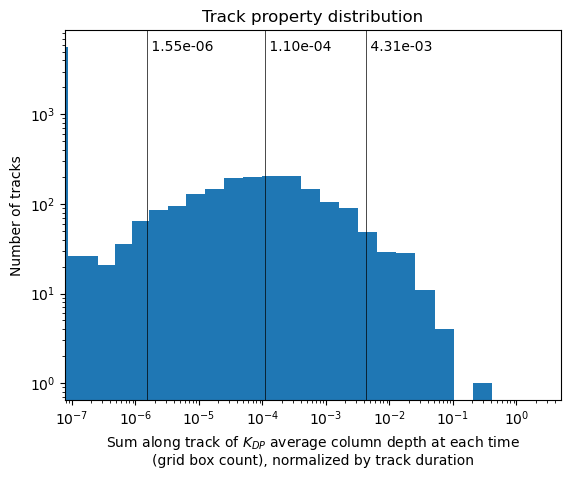

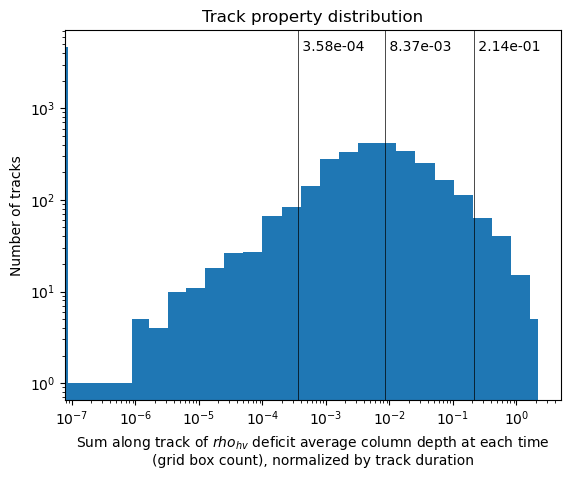

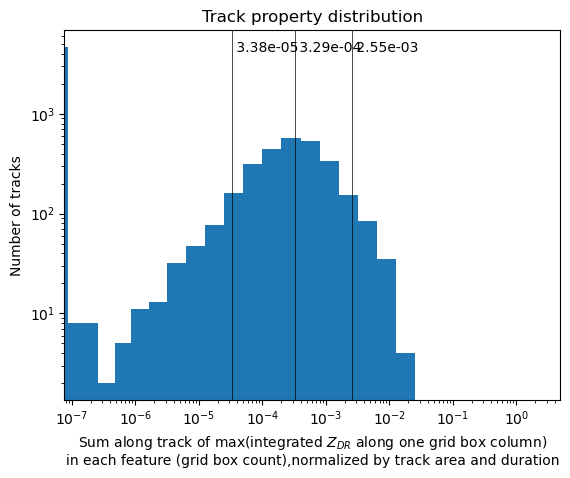

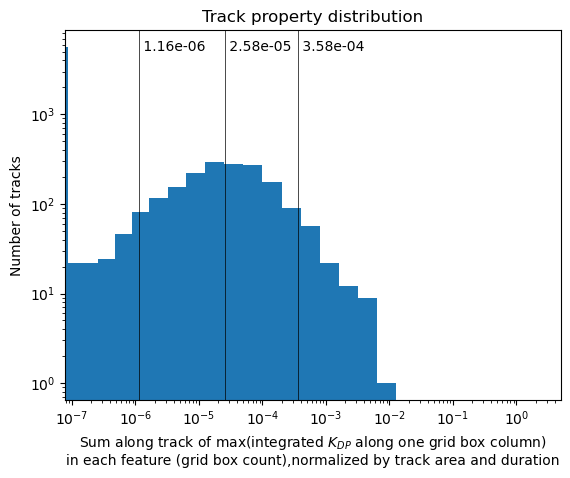

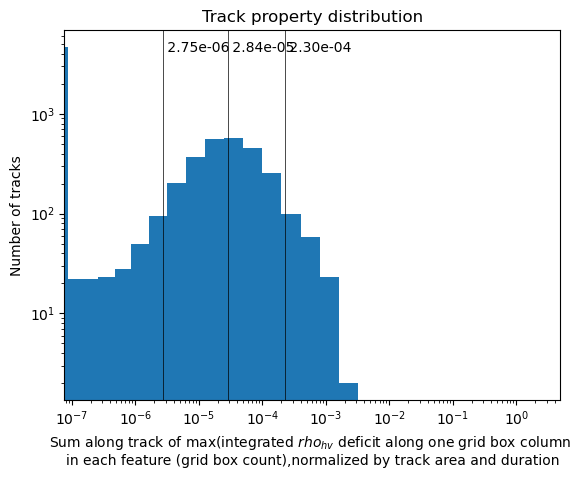

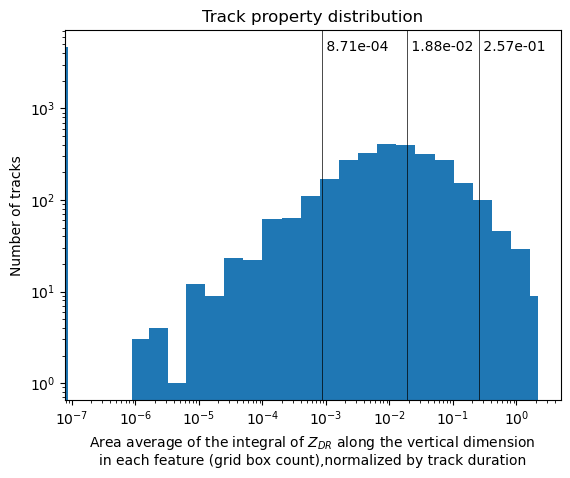

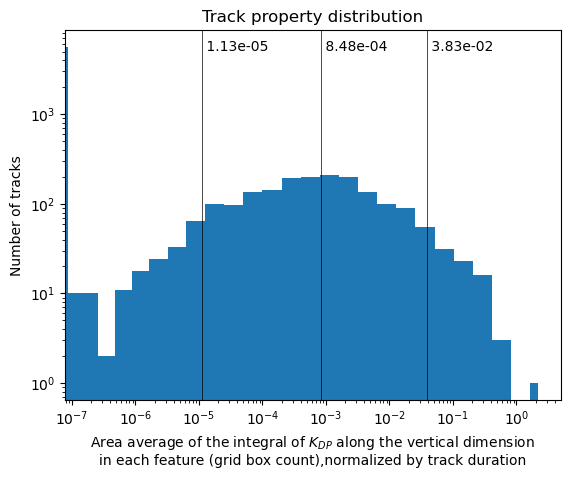

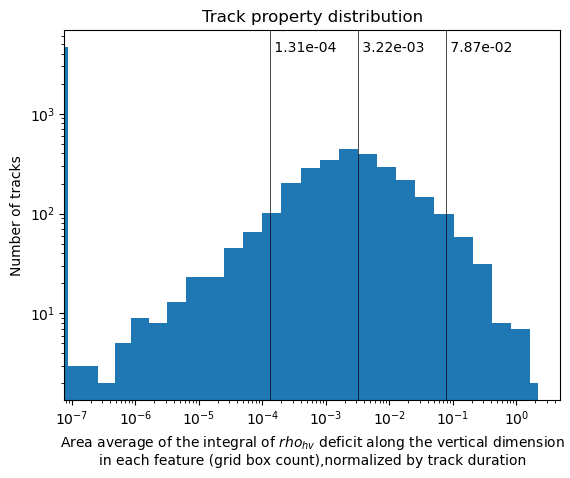

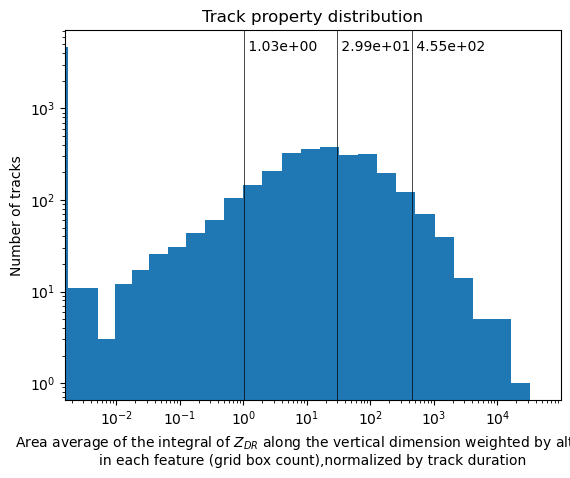

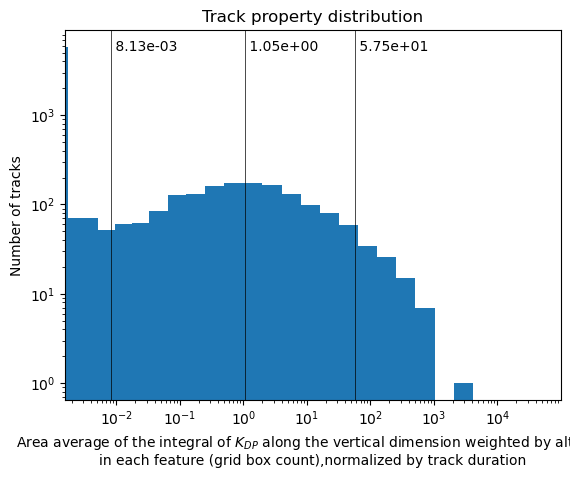

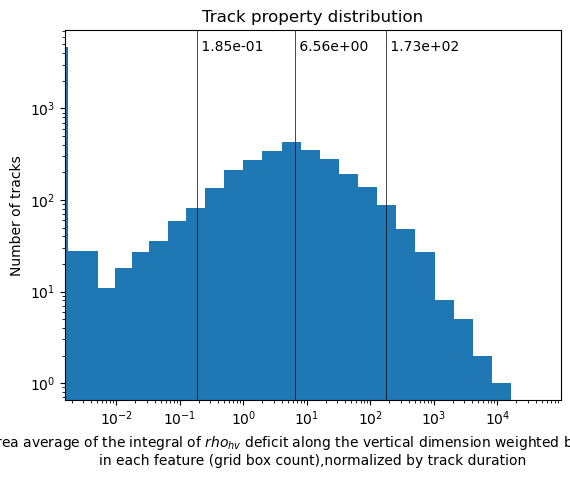

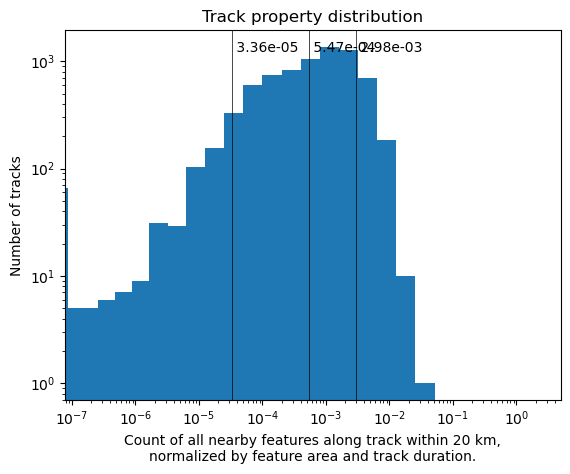

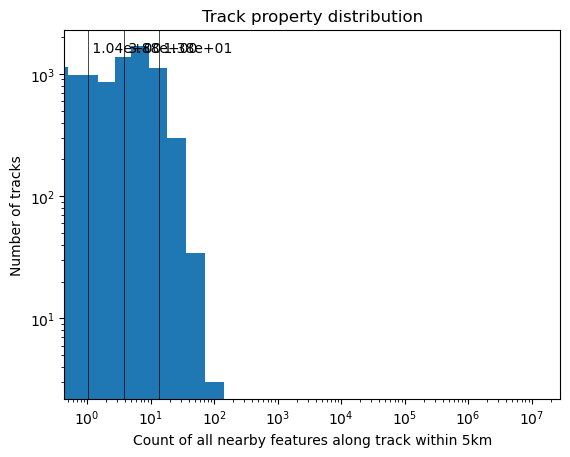

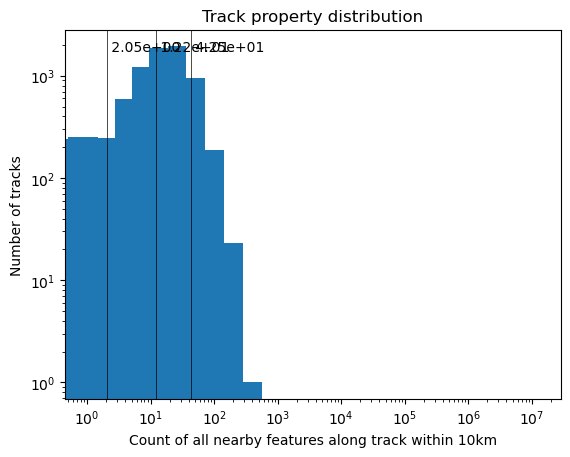

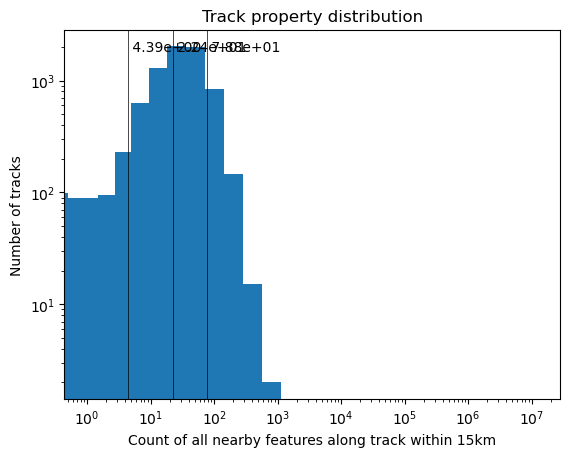

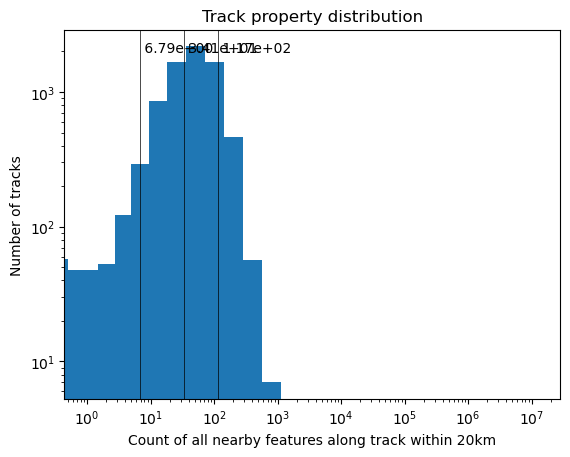

In [28]:
plot_1d_hists(agg_histo_ds)

In [29]:
# plot_1d_hists(histo_ds2)

In [51]:
from matplotlib.colors import LogNorm

def plot_2d_hists(histo_ds_all, plot_hist_names=None, normed=True):
    # Look at a representative dataset
    histo_ds = histo_ds_all[0]
    # Find the 2D histogram variables
    all_histo_names = sorted(k for k in histo_ds.data_vars.keys() if (len(histo_ds[k].dims)==2))
    # print(all_histo_names)          
    # only plot the normed histograms
    if plot_hist_names is None:
        if normed == True:
            plot_hist_names = [s for s in all_histo_names if (s.count('norm') == 2)]
        else:
            plot_hist_names = [s for s in all_histo_names if s.count('norm') == 0]
    
    hist_count = len(plot_hist_names)
    print(f"plotting {hist_count} histograms")
    combo_rows = int(np.ceil(hist_count/3))
    fig, axs = plt.subplots(combo_rows,3, figsize=(2*8, 2*combo_rows*2))
    all_axs = axs.flatten()
    
    for axi, var_name in enumerate(plot_hist_names):
        

        all_h = sum(hds[var_name] for hds in histo_ds_all)
        h = histo_ds[var_name]
        ax = all_axs[axi]
        bins = h[h.coords.dims[0]].values, h[h.coords.dims[1]].values
        all_h.T.plot(levels=17, norm=LogNorm(vmin=1, vmax=128), ax=ax)
        # Need to have the lower limit be the first bin so that it's nonnegative.
        ax.axis((bins[0][1]/10, bins[0][-1], bins[1][1]/10, bins[1][-1]))
        # ax.axis((0.1, 2048, 0.1, 2048))
        
        # Skip the first bin so that we ignore the zero-valued part of the histogram
        regress_plot(all_h[1:, 1:].T, ax, log=False)
        
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.tight_layout()
    return fig

In [52]:
def plot_paper_hists(histo_ds_all, paper_vars, normed=True):
    histo_ds = histo_ds_all[0]
    
    paper_var_histos = list(combinations(paper_vars,2))
    subplot_rows_cols = len(paper_vars)-1

    fig, axs = plt.subplots(subplot_rows_cols,subplot_rows_cols, figsize=(2*8.5, 2*8.5))
    all_axs = axs.flatten()

    # Plot a the triangular upper half
    row, column = 0, 0
    for paper_histo in paper_var_histos:
        var_name = '_'.join(['histogram', paper_histo[0], paper_histo[1]])
        # print(row, column, var_name)
        
        all_h = sum(hds[var_name] for hds in histo_ds_all)
        h = histo_ds[var_name]
        ax = axs[row,column]
        bins = h[h.coords.dims[0]].values, h[h.coords.dims[1]].values
        art = all_h.T.plot(levels=17, norm=LogNorm(vmin=1, vmax=128), ax=ax, cbar_ax=axs[3,0], cbar_kwargs={'label':None})
        art.set_rasterized(True)
        # Need to have the lower limit be the first bin so that it's nonnegative.
        ax.axis((bins[0][1]/10, bins[0][-1], bins[1][1]/10, bins[1][-1]))

        # Skip the first bin so that we ignore the zero-valued part of the histogram
        regress_plot(all_h[1:, 1:].T, ax, log=False)

        
        # ax.axis((0.1, 2048, 0.1, 2048))
        ax.set_xscale('log')
        ax.set_yscale('log')

        if column == 3: 
            row += 1
            column = row
        else:
            column += 1

    fig.tight_layout()
    return fig

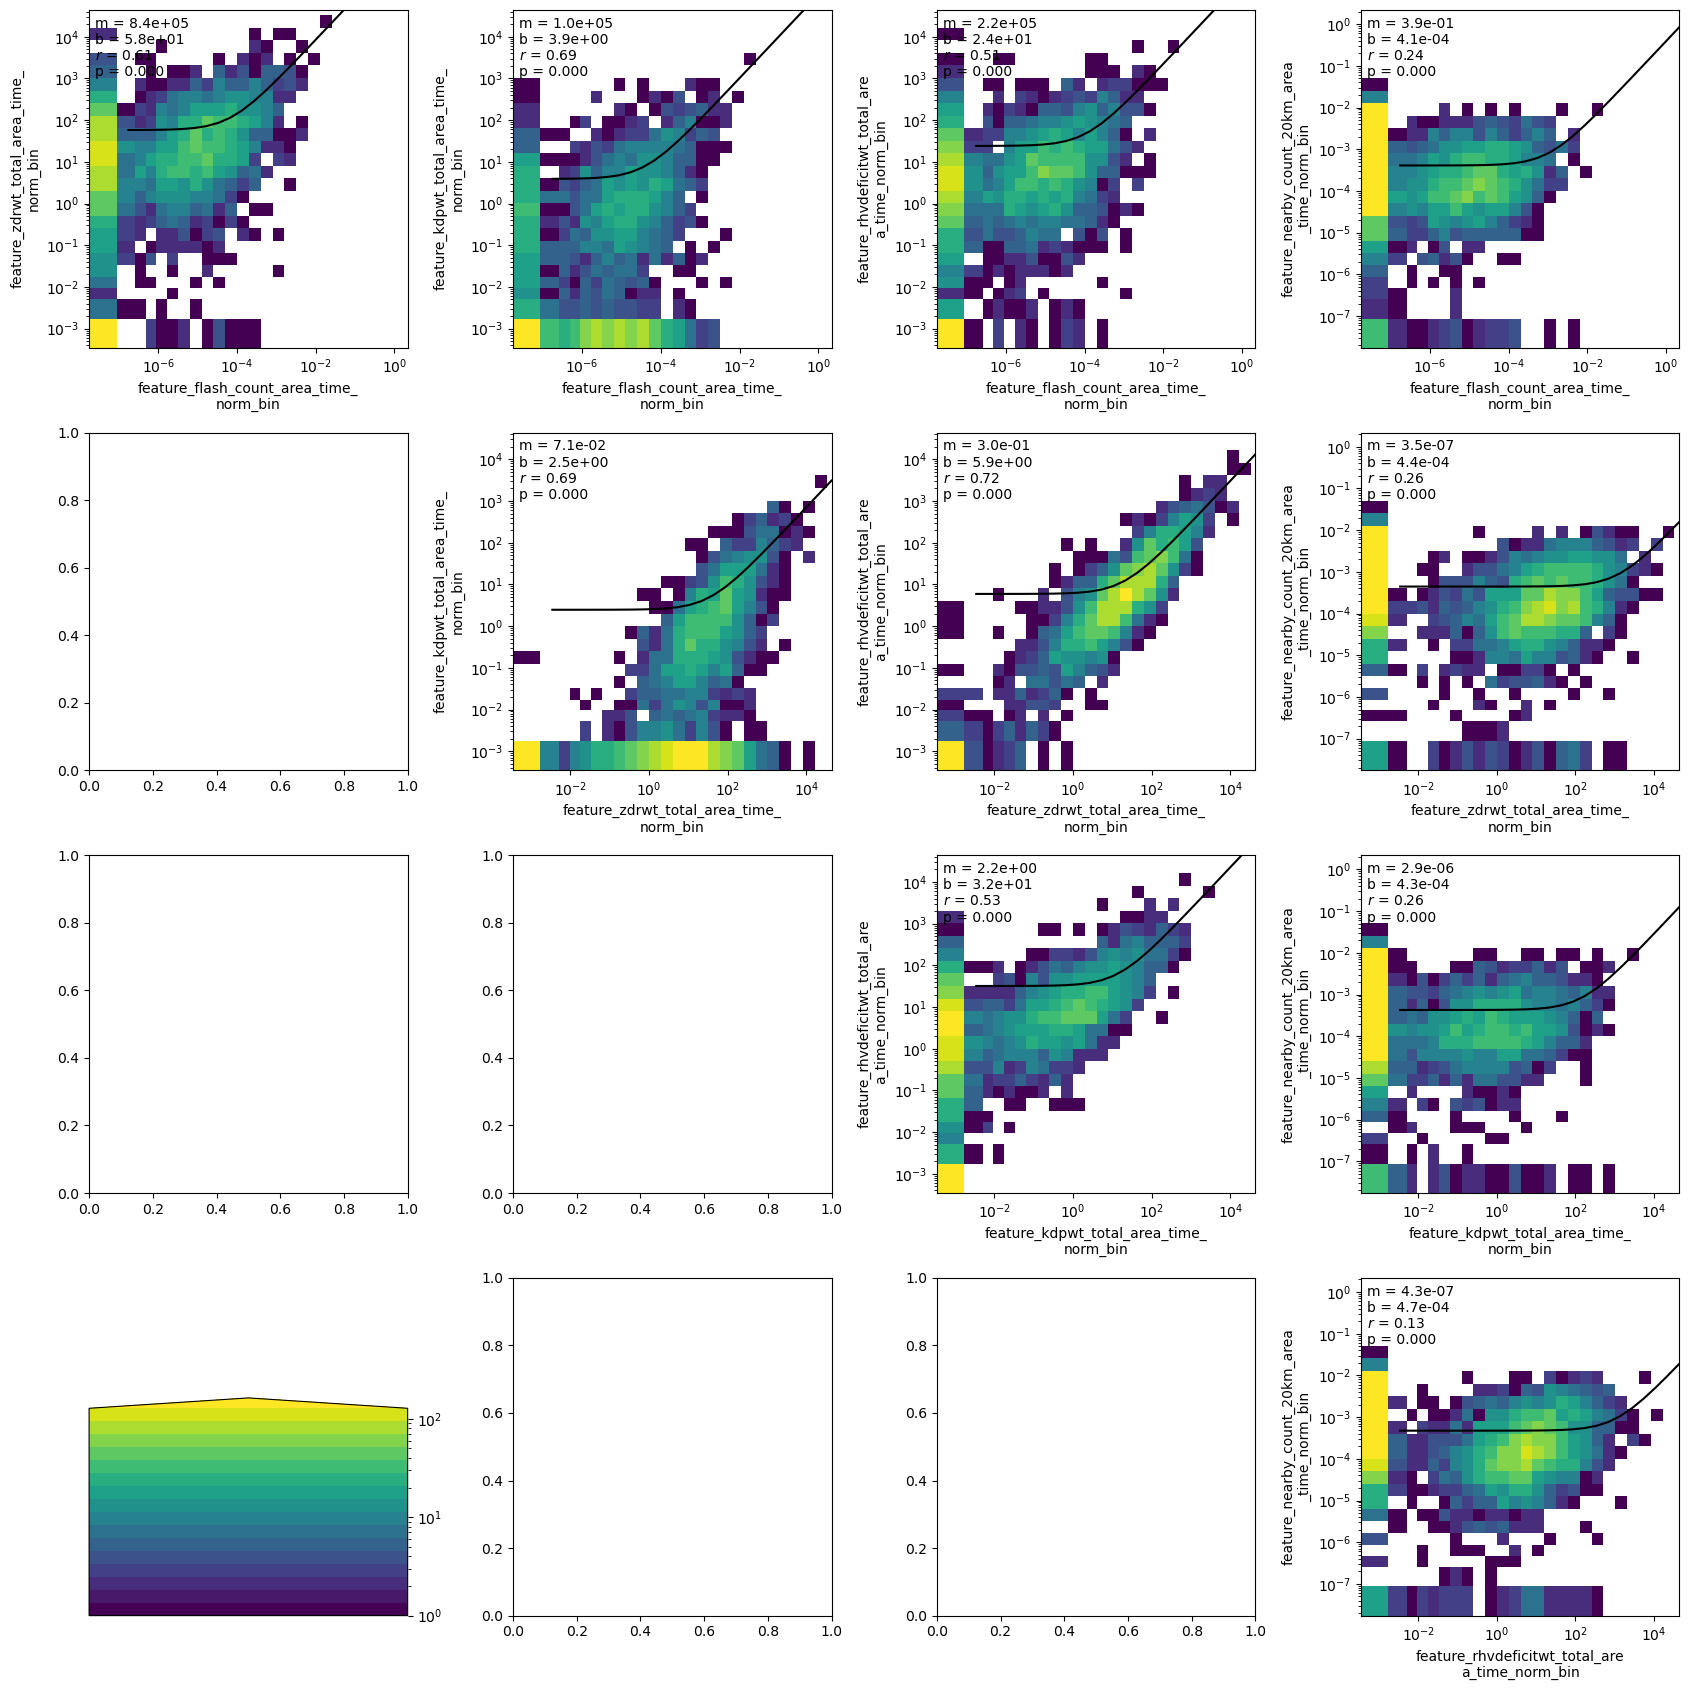

In [53]:
fig_paper = plot_paper_hists([agg_histo_ds], paper_vars)

plotting 91 histograms


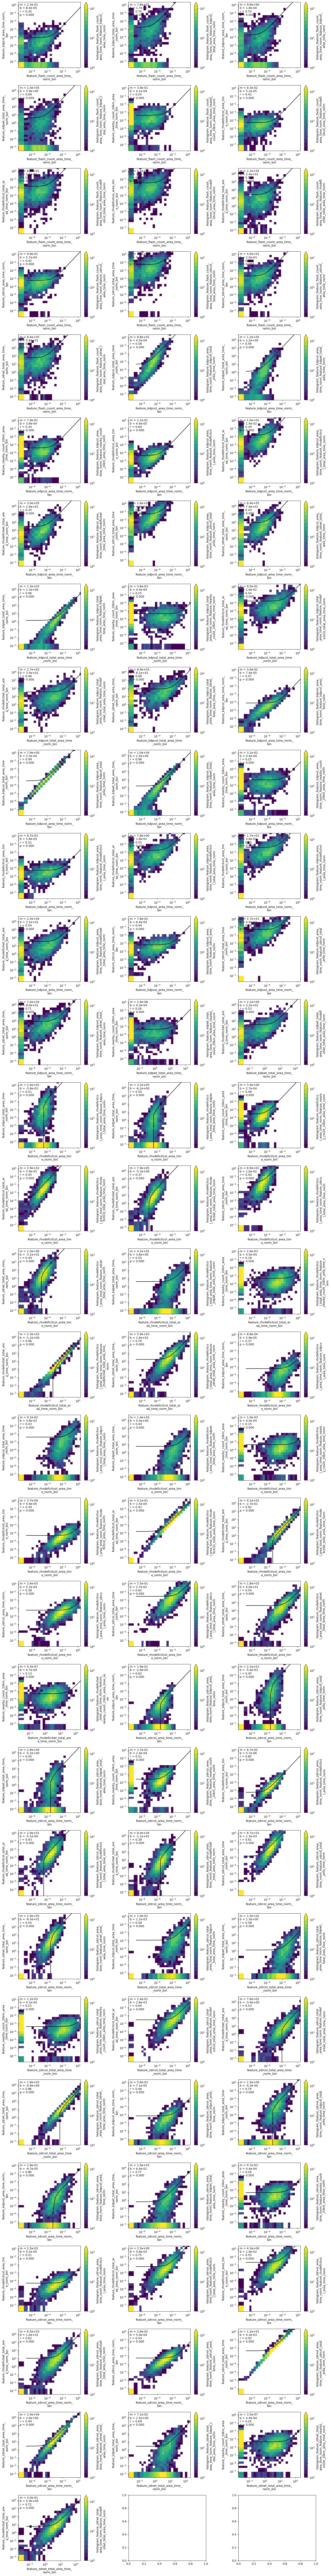

In [54]:
show_normed = True
if show_normed==False:
    norm_extension = '_raw'
else:
    norm_extension = ''

fig = plot_2d_hists([agg_histo_ds], normed=show_normed)

In [55]:
if this_quartile is not None:
    quartile_marker = f'_Q{this_quartile}'
else:
    quartile_marker = ''

if quartiles_by_all_track_count == False:
    quartile_count_type = '-by-zdr-kdp-ltg-count'
else:
    quartile_count_type = ''

In [56]:

if const_melt:
    fig.savefig('joint_histos_constmelt'+norm_extension+'_'+this_category.replace('_','-')+quartile_marker+quartile_count_type+'.pdf')
    fig_paper.savefig('joint_histos_constmelt_paper'+norm_extension+'_'+this_category.replace('_','-')+quartile_marker+quartile_count_type+'.pdf')
else:
    fig.savefig('joint_histos_varymelt'+norm_extension+'_'+this_category.replace('_','-')+'.pdf')
    fig_paper.savefig('joint_histos_varymelt_paper'+norm_extension+'_'+this_category.replace('_','-')+'.pdf')

In [29]:
# plot_2d_hists([histo_ds, histo_ds2])

## Consolidated histograms to match Brunner et al. (2023)

In [310]:
print(zdr_categories)
print(kdp_categories)
print(zdr_ltg_categories)
print(kdp_ltg_categories)

['track_has_zdr_kdp_ltg', 'track_has_zdr_kdp_only', 'track_has_zdr_ltg_only', 'track_has_zdr_only']
['track_has_zdr_kdp_ltg', 'track_has_zdr_kdp_only', 'track_has_kdp_only', 'track_has_kdp_ltg_only']
['track_has_zdr_kdp_ltg', 'track_has_zdr_ltg_only']
['track_has_zdr_kdp_ltg', 'track_has_kdp_ltg_only']


In [311]:
path_template = '/efs/tracer/NEXRAD/tobac_Save_2022*/histogram_data_{0}_melt4400.nc'
# all days
from itertools import chain
pathstrings_all_zdr = list(
    [(c, sorted(glob(path_template.format(c.replace('_','-'))))) for c in zdr_categories]
)
pathstrings_zdr_ltg = list(
    [(c, sorted(glob(path_template.format(c.replace('_','-'))))) for c in zdr_ltg_categories]
)
pathstrings_all_kdp = list(
    [(c, sorted(glob(path_template.format(c.replace('_','-'))))) for c in kdp_categories]
)
pathstrings_kdp_ltg = list(
    [(c, sorted(glob(path_template.format(c.replace('_','-'))))) for c in kdp_ltg_categories]
)

In [312]:
def plot_1d_hists(histo_ds, var_names=None, title=''):
    all_dims = list(histo_ds.dims.keys())
    dims_to_remove = [d for d in all_dims if d != 'percentile_thresholds']
    try:
        percentile_ds = histo_ds.drop_dims(dims_to_remove).drop('grid_time_start').drop('grid_time_end')
    except ValueError:
        # print("Not dropping grid time start and end - not in the dataset")
        percentile_ds = histo_ds.drop_dims(dims_to_remove)
    percentile_ds = percentile_ds.drop('track_maximum_distance_km')
    
    # n_vars = len(percentile_ds.variables.keys())
    # violin_fig, violin_ax = plt.subplots(1,n_vars, figsize=(3,n_vars))
    
    all_figs = []
    if var_names is None:
        var_names = percentile_ds.variables
    for var in var_names:
        bins = histo_ds[var.replace('percentile_','')+'_bin']
        counts = histo_ds[var.replace('percentile_','')]
        total_count = int(counts.values.sum())
        description = counts.attrs['long_name']
        fig, ax = plt.subplots(1,1)

        # ax.step(bins, counts, where='mid')
        ax.fill_between(bins, counts, step='mid')
        for linei, (thresh, thresh_val) in enumerate(zip(percentile_ds['percentile_thresholds'], percentile_ds[var])):
            ax.axvline(thresh_val, color='k', linewidth=0.5)
            ax.text(thresh_val, counts.max()*(.9-.1*linei), f' {thresh_val:3.2e}')
        # ax.set_xlim(-1,15)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel("Number of tracks")
        ax.set_xlabel(description)
        ax.set_title(title+f', total {total_count}')
        all_figs.append(fig)
        
    return all_figs #, violin_fig, 

In [ ]:
histo_var = 'feature_flash_count_area_time_norm'

for title, p in pathstrings_all_zdr:
    print(title)
    agg = aggregate_histos(p)
    hist_vars = [v for v in agg.variables.keys() if (v.startswith('feature_')) & (not('bin' in v))]
    # for v in hist_vars:
    #     print("    ", v, agg[v][0].values, agg[v].sum().values)
    # print("2D ZdrWt vs. neighbor count", agg.histogram_feature_zdrwt_total_area_time_norm_feature_nearby_count_20km.sum().values)
    all_zdr_figs = plot_1d_hists(agg, var_names=['percentile_'+histo_var], title=title)
    outname = 'distribution_'+histo_var.replace('feature_', '').replace('_', '-')+'_for_'+title.replace('_', '-')+'.pdf'
    print(outname)
    all_zdr_figs[0].savefig(outname)

track_has_zdr_kdp_ltg
distribution_flash-count-area-time-norm_for_track-has-zdr-kdp-ltg.pdf
track_has_zdr_kdp_only
distribution_flash-count-area-time-norm_for_track-has-zdr-kdp-only.pdf
track_has_kdp_only


/tmp/ipykernel_421/1891211272.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


distribution_flash-count-area-time-norm_for_track-has-kdp-only.pdf
track_has_kdp_ltg_only
distribution_flash-count-area-time-norm_for_track-has-kdp-ltg-only.pdf


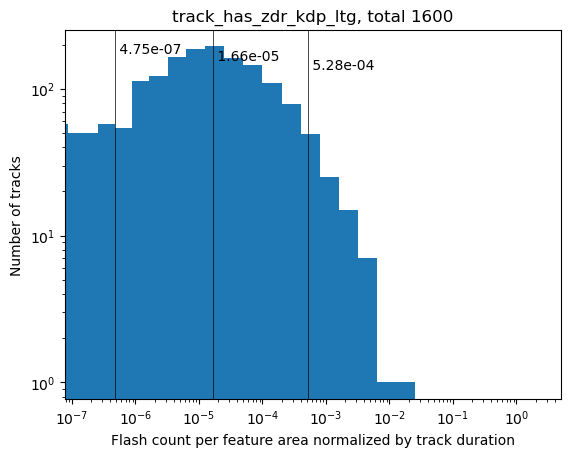

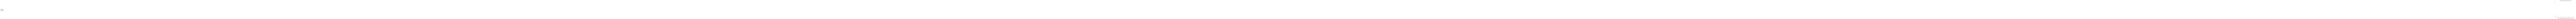

ValueError: Image size of 63574x336396 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

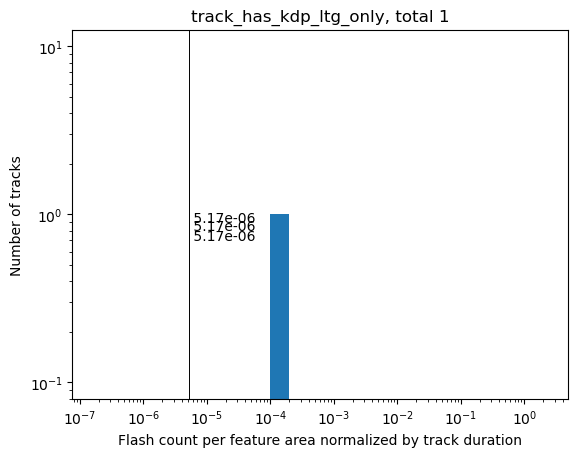

In [13]:
histo_var = 'feature_flash_count_area_time_norm'

for title, p in pathstrings_all_kdp:
    print(title)
    agg = aggregate_histos(p)
    hist_vars = [v for v in agg.variables.keys() if (v.startswith('feature_')) & (not('bin' in v))]
    # for v in hist_vars:
    #     print("    ", v, agg[v][0].values, agg[v].sum().values)
    # print("2D ZdrWt vs. neighbor count", agg.histogram_feature_zdrwt_total_area_time_norm_feature_nearby_count_20km.sum().values)
    all_zdr_figs = plot_1d_hists(agg, var_names=['percentile_'+histo_var], title=title)
    outname = 'distribution_'+histo_var.replace('feature_', '').replace('_', '-')+'_for_'+title.replace('_', '-')+'.pdf'
    print(outname)
    all_zdr_figs[0].savefig(outname)

track_has_zdr_kdp_ltg
distribution_flash-count-area-time-norm_for_track-has-zdr-kdp-ltg.pdf
track_has_zdr_kdp_only
distribution_flash-count-area-time-norm_for_track-has-zdr-kdp-only.pdf
track_has_zdr_ltg_only
distribution_flash-count-area-time-norm_for_track-has-zdr-ltg-only.pdf
track_has_zdr_only
distribution_flash-count-area-time-norm_for_track-has-zdr-only.pdf


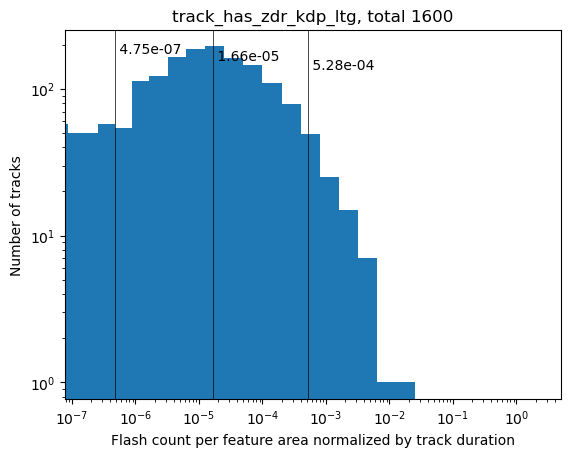

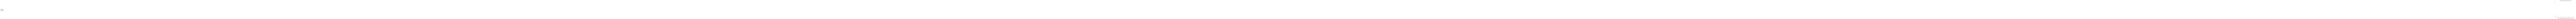

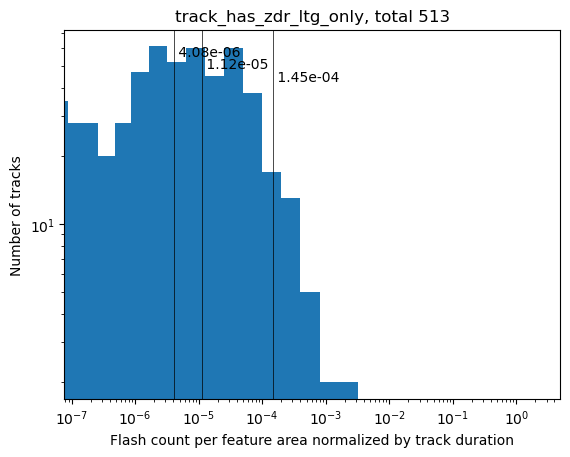

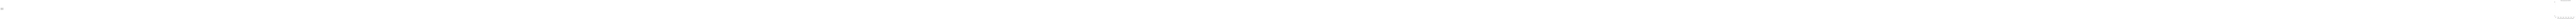

In [12]:
histo_var = 'feature_zdrwt_total_area_time_norm'

for title, p in pathstrings_all_zdr:
    print(title)
    agg = aggregate_histos(p)
    hist_vars = [v for v in agg.variables.keys() if (v.startswith('feature_')) & (not('bin' in v))]
    # for v in hist_vars:
    #     print("    ", v, agg[v][0].values, agg[v].sum().values)
    # print("2D ZdrWt vs. neighbor count", agg.histogram_feature_zdrwt_total_area_time_norm_feature_nearby_count_20km.sum().values)
    all_zdr_figs = plot_1d_hists(agg, var_names=['percentile_'+histo_var], title=title)
    outname = 'distribution_'+histo_var.replace('feature_', '').replace('_', '-')+'_for_'+title.replace('_', '-')+'.pdf'
    print(outname)
    all_zdr_figs[0].savefig(outname)

distribution_kdpwt-total-area-time-norm_for_track-has-zdr-kdp-ltg.pdf
distribution_kdpwt-total-area-time-norm_for_track-has-zdr-kdp-only.pdf


/tmp/ipykernel_21595/1891211272.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


distribution_kdpwt-total-area-time-norm_for_track-has-kdp-only.pdf
distribution_kdpwt-total-area-time-norm_for_track-has-kdp-ltg-only.pdf


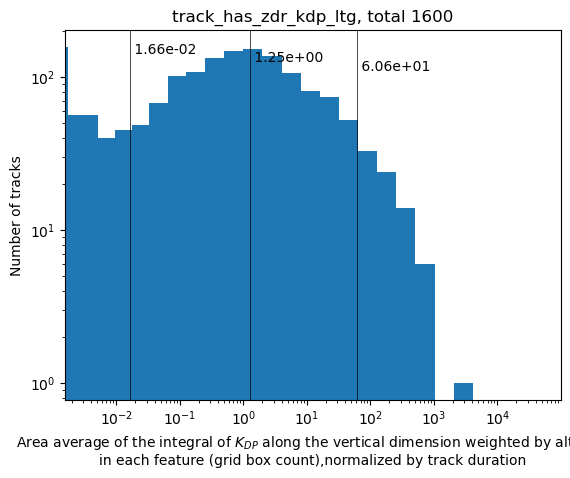

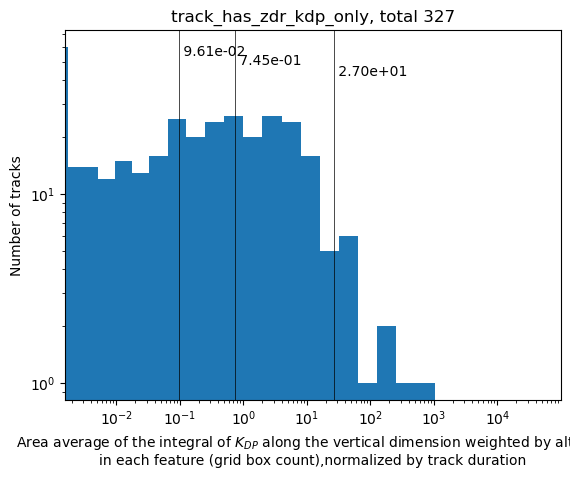

ValueError: Image size of 63847x336396 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

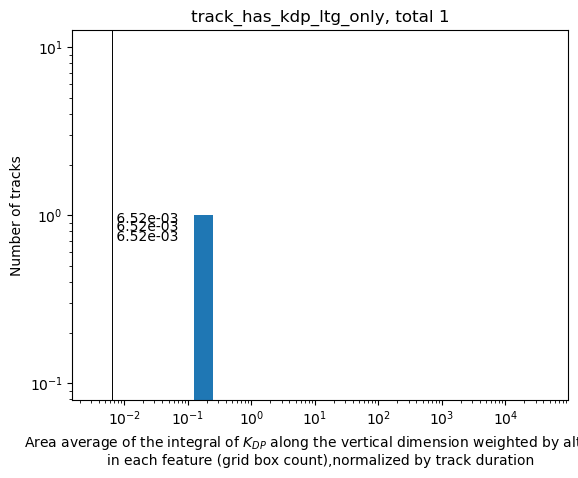

In [314]:
histo_var = 'feature_kdpwt_total_area_time_norm'

for title, p in pathstrings_all_kdp:
    all_kdp_figs = plot_1d_hists(aggregate_histos(p), var_names=['percentile_'+histo_var], title=title)
    outname = 'distribution_'+histo_var.replace('feature_', '').replace('_', '-')+'_for_'+title.replace('_', '-')+'.pdf'
    print(outname)
    all_kdp_figs[0].savefig(outname)
        